In [5]:
from scipy.io import arff
from ts2vec import TS2Vec
import datautils


In [1]:
import os
import time
import datetime
import json
import shutil
import numpy as np
import pandas as pd
# import folium # draw route on map
# from folium import plugins
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path


import matplotlib.pyplot as plt
# %matplotlib inline
# import plotly.express as px
# import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS,  DBSCAN, Birch 


print(np.__version__)
print(pd.__version__)


1.23.5
1.0.1


In [ ]:
#!pip install liac-arff
# import arff

In [7]:
from scipy.io import arff

dataset = 'BasicMotions'
data = arff.loadarff(f'datasets/UEA/{dataset}/{dataset}_TRAIN.arff')[0]


In [10]:
def extract_data(data):
    res_data = []
    res_labels = []
    for t_data, t_label in data:
        t_data = np.array([ d.tolist() for d in t_data ])
        t_label = t_label.decode("utf-8")
        res_data.append(t_data)
        res_labels.append(t_label)
    return np.array(res_data).swapaxes(1, 2), np.array(res_labels)

()

In [15]:

df = pd.DataFrame(data)

df.head()

,relationalAtt,activity
0,"[[0.079106, 0.079106, -0.903497, 1.116125, 1.6...",b'Standing'
1,"[[0.377751, 0.377751, 2.952965, 4.310925, 3.25...",b'Standing'
2,"[[-0.813905, -0.813905, -0.424628, 0.316895, 0...",b'Standing'
3,"[[0.289855, 0.289855, -0.669185, 0.032063, -0....",b'Standing'
4,"[[-0.123238, -0.123238, -0.249547, -0.272929, ...",b'Standing'


In [82]:

# Load the ECG200 dataset from UCR archive
train_data, train_labels, test_data, test_labels = datautils.load_UEA('BasicMotions')
# (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)
train_data.shape


(40, 100, 6)

In [ ]:
c_method = 'OPTICS'
min_samples = 3
max_eps = np.inf # np.inf
xi = 0.05

clustering = OPTICS(min_samples=min_samples, max_eps=max_eps, xi=xi, n_jobs=10).fit(df_event_agg_scaled)
cluster_labels_ = clustering.labels_
n_labels = len(np.unique(cluster_labels_))
print(f'Number of clusters : {n_labels}')
print(f'outlier_perc : = {(np.sum(cluster_labels_== -1)/ len(cluster_labels_))*100 :.2f} %')
cluster_labels_

In [102]:
n_feature = train_data.shape[-1]
# Train a TS2Vec model
model = TS2Vec(
    input_dims=n_feature,
    device='cpu',
    output_dims=320
)


In [103]:

loss_log = model.fit(
    train_data,
    verbose=True
)


Epoch #0: loss=17.907253742218018
Epoch #1: loss=16.036823272705078
Epoch #2: loss=7.519722938537598
Epoch #3: loss=4.572880744934082
Epoch #4: loss=3.0226281881332397
Epoch #5: loss=3.79820716381073
Epoch #6: loss=3.270593285560608
Epoch #7: loss=3.0883854627609253
Epoch #8: loss=3.104858636856079
Epoch #9: loss=2.5742647647857666
Epoch #10: loss=2.933247923851013
Epoch #11: loss=3.0357825756073
Epoch #12: loss=2.800729990005493
Epoch #13: loss=2.928725481033325
Epoch #14: loss=2.869333028793335
Epoch #15: loss=2.699778914451599
Epoch #16: loss=2.823645234107971
Epoch #17: loss=2.590148448944092
Epoch #18: loss=2.6274611949920654
Epoch #19: loss=2.7886691093444824
Epoch #20: loss=2.6365625858306885
Epoch #21: loss=2.3846168518066406
Epoch #22: loss=2.7021095752716064
Epoch #23: loss=2.5948294401168823
Epoch #24: loss=2.445379853248596
Epoch #25: loss=2.627063751220703
Epoch #26: loss=2.494326114654541
Epoch #27: loss=2.637471556663513
Epoch #28: loss=2.4228675365448
Epoch #29: loss=2.

In [18]:

# Compute timestamp-level representations for test set
test_repr = model.encode(test_data)  # n_instances x n_timestamps x output_dims
test_repr.shape


(100, 96, 320)

In [104]:

# Compute instance-level representations for test set
test_repr_2d = model.encode(test_data, encoding_window='full_series')  # n_instances x output_dims
test_repr_2d.shape


(40, 320)

In [90]:
test_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [105]:
n_components=2
pca = PCA(n_components=n_components)
pca.fit(test_repr_2d)
explained_v_ratio = pca.explained_variance_ratio_.sum()
print(f'explained_variance_ratio : {100*explained_v_ratio:.2f}%')
# explained_variance_ratios.append(100*explained_variance_ratio)
# print(f'N : {n:2d}, N_union : {len(index_n_unions[n-1]):3d}, Explained_variance_ratio : {100*explained_variance_ratio:.2f} %', end='\r')

pca_embed = pca.transform(test_repr_2d)

explained_variance_ratio : 83.19%


In [106]:
c_method = 'OPTICS'
min_samples = 3
max_eps = 1.0 # np.inf
xi = 0.05

clustering = OPTICS(min_samples=min_samples, max_eps=max_eps, xi=xi, n_jobs=10).fit(test_repr_2d)
cluster_labels_ = clustering.labels_
n_labels = len(np.unique(cluster_labels_))
print(f'Number of clusters : {n_labels}')
print(f'outlier_perc : = {(np.sum(cluster_labels_== -1)/ len(cluster_labels_))*100 :.2f} %')
cluster_labels_

Number of clusters : 3
outlier_perc : = 70.00 %


array([-1, -1, -1,  0,  0,  0, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])

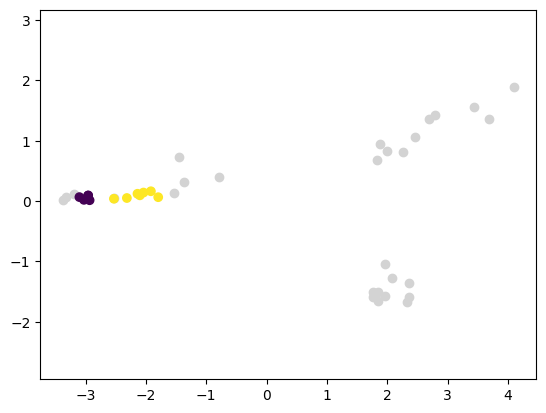

In [107]:
m_outlier =  cluster_labels_ == -1
plt.scatter(
    pca_embed[m_outlier, 0],
    pca_embed[m_outlier, 1],
    c='lightgrey')
# plt.gca().set_aspect('equal', 'datalim')

plt.scatter(
    pca_embed[~m_outlier, 0],
    pca_embed[~m_outlier, 1],
    c=cluster_labels_[~m_outlier])
plt.gca().set_aspect('equal', 'datalim')

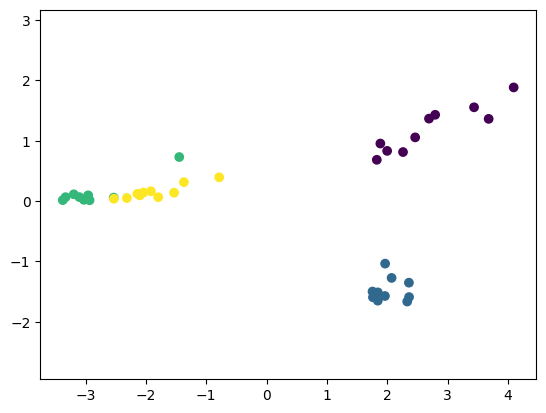

In [108]:
plt.scatter(
    pca_embed[:, 0],
    pca_embed[:, 1],
    c=test_labels)
plt.gca().set_aspect('equal', 'datalim')

In [109]:
import umap
reducer = umap.UMAP()

In [110]:
embedding = reducer.fit_transform(test_repr_2d)
embedding.shape

(40, 2)

In [111]:
test_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

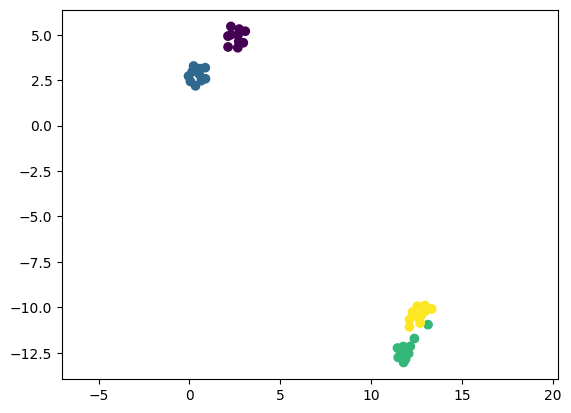

In [112]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=test_labels)
plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the Penguin dataset', fontsize=24);

In [20]:

# Sliding inference for test set
test_repr = model.encode(
    test_data,
    casual=True,
    sliding_length=1,
    sliding_padding=50
)  # n_instances x n_timestamps x output_dims
# (The timestamp t's representation vector is computed using the observations located in [t-50, t])
test_repr.shape

(100, 96, 320)